In [1]:
# --- Импорты ---
import os
import datetime
import multiprocessing
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import requests

import torchvision
import torchvision.utils as vutils
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from vae_v1 import VAE, VGGPerceptualLoss

In [2]:
# --- Гиперпараметры обучения и модели ---
BATCH_SIZE = 64
# Размер пакета данных для одной итерации обучения.
# Большее значение ускоряет обучение, но требует больше видеопамяти.
LATENT_DIM = 128 * 4
# Размерность латентного пространства (вектора z).
# Чем больше размерность, тем богаче потенциальная вариативность генерируемых изображений.
IMAGE_SIZE = 128 * 2
# Размер входных изображений (высота и ширина в пикселях).
# Должен быть кратным 16 для корректной работы архитектуры энкодера и декодера.
EPOCHS = 500
EARLY_STOP = 20 #30
# Общее количество проходов по всему датасету во время обучения.
LEARNING_RATE = 1e-3
# Скорость обучения оптимизатора.
# Малое значение приводит к медленному обучению, большое может вызывать нестабильность.

SAVE_INTERVAL = 100
# Интервал в эпохах для сохранения сгенерированных изображений в процессе обучения.

SAVE_PATH = './models/vae_model.pth'
# Путь для сохранения финальной версии обученной модели.
BEST_MODEL_PATH = './models/vae_best_model.pth'
# Путь для сохранения лучшей модели (по минимальному значению лосса на обучении).
OLD_MODEL = False
# Путь к ранее обученной модели для продолжения обучения или генерации изображений.
# False означает обучение \"с нуля\".

In [3]:
#Folders
OUTPUT = './output'
EPOCHS_FOLDER = os.path.join(OUTPUT, 'epochs')
GENERATED_FOLDER = os.path.join(OUTPUT, 'generated')
MORPH_FOLDER = os.path.join(OUTPUT, 'morph_frames')
Z_FOLDER = os.path.join(OUTPUT, 'z_frames')
LAT_GRID = os.path.join(OUTPUT, 'latent_frames')
GRID_FOLDER = os.path.join(OUTPUT, 'grid')
os.makedirs(OUTPUT, exist_ok=True)
os.makedirs(EPOCHS_FOLDER, exist_ok=True)
os.makedirs(GENERATED_FOLDER, exist_ok=True)
os.makedirs(MORPH_FOLDER, exist_ok=True)
os.makedirs(Z_FOLDER, exist_ok=True)
os.makedirs(LAT_GRID, exist_ok=True)
os.makedirs(GRID_FOLDER, exist_ok=True)

In [4]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using DEVICE: {DEVICE}")
with torch.no_grad():
    torch.cuda.empty_cache()

Using DEVICE: cuda


In [5]:
# Подготовка данных
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

In [6]:
# Создание загрузчиков данных
num_workers = min(16, multiprocessing.cpu_count())
prefetch_factor = 128#* 2

In [7]:
dataset = datasets.ImageFolder(root='data', transform=transform)
#dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,           # обязательно перемешивание
    num_workers=num_workers,           # или другое оптимальное число
    pin_memory=True,
    prefetch_factor=prefetch_factor,       # если много CPU
    persistent_workers=True  # если поддерживается версией
)

print(f"Loaded {len(dataset)} images from 'data'")

Loaded 1800 images from 'data'


In [8]:
# Инициализируем Perceptual Loss
perceptual_loss_fn = VGGPerceptualLoss().to(DEVICE)

def vae_loss_function(recon_x, x, mu, logvar, alpha=1.0, beta=0.1):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    perceptual_loss = perceptual_loss_fn(recon_x, x) * x.size(0)  # Масштабируем под батч
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    total_loss = alpha * recon_loss + beta * perceptual_loss + kl_loss
    return total_loss

def loss_function(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

In [9]:
# Вспомогательные функции
def plot_loss(losses):
    plt.figure(figsize=(8, 6))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Эпоха')
    plt.ylabel('Потери')
    plt.title('График изменения потерь')
    plt.legend()
    plt.show()

def imshow(img):
    img = np.array(img)
    if img.min() < 0:
        img -= img.min()
        img /= img.max()
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.axis('off')
    plt.show()

In [10]:
# Инициализация модели
vae = VAE(LATENT_DIM, IMAGE_SIZE).to(DEVICE)
if OLD_MODEL:
    vae.load_state_dict(torch.load(OLD_MODEL, map_location=DEVICE))
    print("Loaded model from", OLD_MODEL)
optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE)

In [11]:
# Обучение модели
losses = []
best_loss = float('inf')

In [12]:
for epoch in range(EPOCHS):
    tstart = datetime.datetime.now()
    vae.train()
    train_loss = 0
    for imgs, _ in dataloader:
        imgs = imgs.to(DEVICE)
        optimizer.zero_grad()
        recon_imgs, mu, logvar = vae(imgs)
        #loss = loss_function(recon_imgs, imgs, mu, logvar)
        loss = vae_loss_function(recon_imgs, imgs, mu, logvar)
        #loss = perceptual_loss_fn(recon_x, x) * batch_size 

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_loss = train_loss / len(dataset)
    losses.append(avg_loss)

    print(f"\nEpoch [{epoch + 1}/{EPOCHS}], Train Loss: {avg_loss:.4f}")
    print(f"Время: {str(datetime.datetime.now() - tstart).split('.')[0]}")
    # Сохраняем лучшую модель
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_model = vae
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"val_loss: {avg_loss:.4f} > best_loss: {best_loss:.4f}, попытка {patience_counter}")
        if patience_counter >= EARLY_STOP:
            print("Ранняя остановка!")
        break
    # Периодически генерируем изображения
    if (epoch + 1) % SAVE_INTERVAL == 0:
        vae.eval()
        with torch.no_grad():
            z = torch.randn(4, LATENT_DIM).to(DEVICE)
            samples = vae.decoder(z)
        vutils.save_image(samples.cpu(), f'{EPOCHS_FOLDER}/generated_faces_epoch_{epoch+1}.png', nrow=4)
        #imshow(torchvision.utils.make_grid(samples.cpu()))


Epoch [1/500], Train Loss: 16313.2374
Время: 0:02:31

Epoch [2/500], Train Loss: 6677.4746
Время: 0:01:26

Epoch [3/500], Train Loss: 5618.6923
Время: 0:01:25

Epoch [4/500], Train Loss: 5321.9262
Время: 0:01:25

Epoch [5/500], Train Loss: 5068.5754
Время: 0:01:27

Epoch [6/500], Train Loss: 4440.3408
Время: 0:01:28

Epoch [7/500], Train Loss: 3966.5508
Время: 0:01:28

Epoch [8/500], Train Loss: 3847.9035
Время: 0:01:28

Epoch [9/500], Train Loss: 3661.0610
Время: 0:01:27

Epoch [10/500], Train Loss: 3535.7506
Время: 0:01:27

Epoch [11/500], Train Loss: 3478.7682
Время: 0:01:35

Epoch [12/500], Train Loss: 3346.3077
Время: 0:01:39

Epoch [13/500], Train Loss: 3241.8159
Время: 0:01:27

Epoch [14/500], Train Loss: 3160.3498
Время: 0:01:26

Epoch [15/500], Train Loss: 2895.5749
Время: 0:01:26


KeyboardInterrupt: 

In [ ]:
BESTLoss = 250
best_loss

In [ ]:
# Сохранение финальной модели
if best_loss <= BESTLoss:
    torch.save(best_model.state_dict(), SAVE_PATH)
    print(f"Final model saved to {SAVE_PATH}")

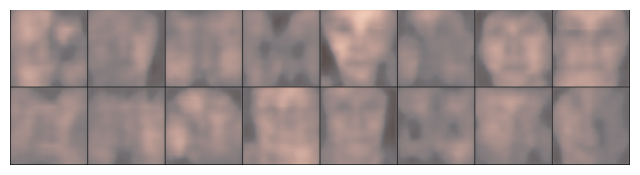

In [14]:
# Генерация итоговых лиц
vae.eval()
with torch.no_grad():
    z = torch.randn(16, LATENT_DIM).to(DEVICE)
    samples = vae.decoder(z)
vutils.save_image(samples.cpu(), f'{GENERATED_FOLDER}/generated_faces_final.png', nrow=4)
imshow(torchvision.utils.make_grid(samples.cpu()))

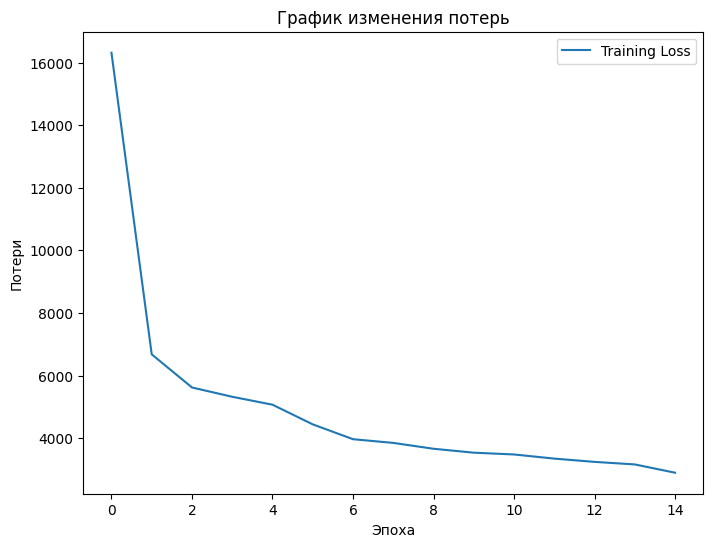

In [15]:
# Построение графика потерь
plot_loss(losses)

In [16]:
# Уведомление о завершении обучения
url = "http://home.teyhd.ru:3334/"
params = {"msg": f"Обучение Автоэнкодера завершено: Эпох {EPOCHS}\nФинальный лосс: {losses[-1]:.6f}"}
try:
    response = requests.get(url, params=params)
    print(f"Notification sent! Status Code: {response.status_code} | Response Text: {response.text}")
except Exception as e:
    print(f"Failed to send notification: {e}")

Notification sent! Status Code: 200 | Response Text: SENDING


### Генерация разных типов z для декодера и создание GIF морфинга

In [17]:
# --- Настройки ---
NUM_PIC = 16  # Количество изображений

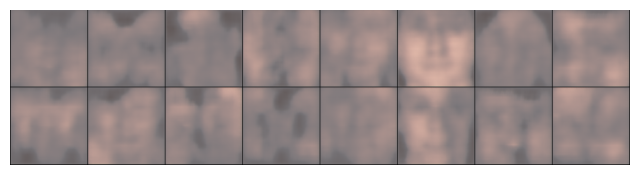

In [18]:
# --- 1. Стандартное сэмплирование (N(0,1)) ---
with torch.no_grad():
    z = torch.randn(NUM_PIC, LATENT_DIM).to(DEVICE)
    samples = vae.decoder(z)
    vutils.save_image(samples.cpu(), f'{Z_FOLDER}/z_random_normal.png', nrow=4)
    imshow(torchvision.utils.make_grid(samples.cpu()))

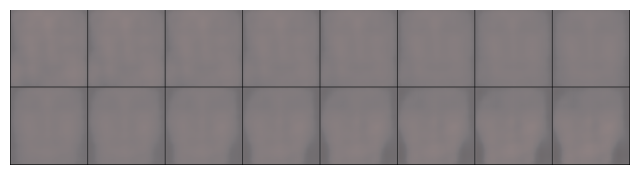

In [19]:
# --- 2. Ручное задание признаков ---
with torch.no_grad():
    z = torch.zeros(NUM_PIC, LATENT_DIM).to(DEVICE)
    z[:, :2] = torch.linspace(-3, 3, NUM_PIC).unsqueeze(1).repeat(1, 2)
    samples = vae.decoder(z)
    vutils.save_image(samples.cpu(), f'{Z_FOLDER}/z_manual_features.png', nrow=4)
    imshow(torchvision.utils.make_grid(samples.cpu()))

In [20]:
# --- 3. Латентные коды реальных изображений ---
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

In [21]:
real_dataset = datasets.ImageFolder(root='data', transform=transform)
real_loader = DataLoader(real_dataset, batch_size=NUM_PIC, shuffle=True)

real_imgs, _ = next(iter(real_loader))
real_imgs = real_imgs.to(DEVICE)

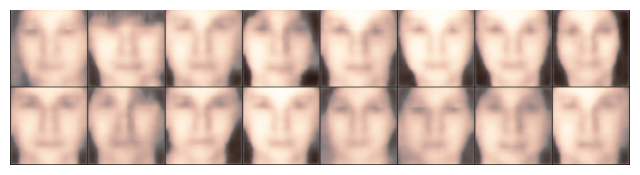

In [22]:
with torch.no_grad():
    mu, logvar = vae.encoder(real_imgs)
    z = vae.reparameterize(mu, logvar)
    samples = vae.decoder(z)
    vutils.save_image(samples.cpu(), f'{Z_FOLDER}/z_from_real_imgs.png', nrow=4)
    imshow(torchvision.utils.make_grid(samples.cpu()))

In [23]:
# --- 4. Интерполяция между двумя точками ---
frames = []
with torch.no_grad():
    z1 = torch.randn(1, LATENT_DIM).to(DEVICE)
    z2 = torch.randn(1, LATENT_DIM).to(DEVICE)
    alphas = torch.linspace(0, 1, steps=30).unsqueeze(1).to(DEVICE)
    z = (1 - alphas) * z1 + alphas * z2
    for i, zi in enumerate(z):
        sample = vae.decoder(zi.unsqueeze(0))
        img_path = f'{MORPH_FOLDER}/frame_{i:03d}.png'
        vutils.save_image(sample.cpu(), img_path, nrow=1)
        frames.append(imageio.imread(img_path))
    imageio.mimsave(f'{MORPH_FOLDER}/morphing.gif', frames, fps=10)
    print("GIF морфинга сохранён как 'morphing.gif'")

GIF морфинга сохранён как 'morphing.gif'


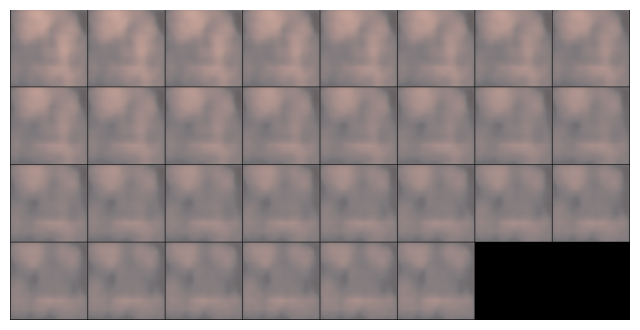

In [24]:
# Показываем последний батч интерполяции
vutils.save_image(vae.decoder(z).cpu(), f'{Z_FOLDER}/z_interpolation.png', nrow=6)
imshow(torchvision.utils.make_grid(vae.decoder(z).cpu()))

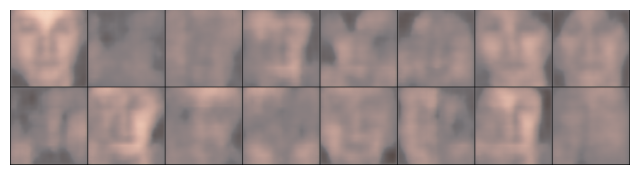

In [25]:
# --- 5. Альтернативное распределение (равномерное) ---
with torch.no_grad():
    z = torch.empty(NUM_PIC, LATENT_DIM).uniform_(-2, 2).to(DEVICE)
    samples = vae.decoder(z)
    vutils.save_image(samples.cpu(), f'{Z_FOLDER}/z_uniform_distribution.png', nrow=4)
    imshow(torchvision.utils.make_grid(samples.cpu()))

### Код для удобного подбора ручных признаков и генерации 2D-сетки лиц + анимация

In [26]:
# --- Настройки ---
GRID_SIZE = 8  # Сетка GRID_SIZE x GRID_SIZE
# Предполагаем, что модель VAE уже загружена и называется "vae"
vae.eval()

VAE(
  (encoder): Encoder(
    (conv): Sequential(
      (0): Conv2d(3, 6, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(6, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(12, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (5): ReLU()
      (6): Conv2d(24, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (7): ReLU()
      (8): Conv2d(48, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (9): ReLU()
      (10): Conv2d(96, 192, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (11): ReLU()
    )
    (fc_mu): Linear(in_features=3072, out_features=512, bias=True)
    (fc_logvar): Linear(in_features=3072, out_features=512, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=512, out_features=3072, bias=True)
    (deconv): Sequential(
      (0): ConvTranspose2d(192, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Con

In [27]:
# --- Удобный подбор параметров ---
def generate_manual_z(fixed_value=0.0, vary_dims=(0, 1), range_min=-3, range_max=3, grid_size=GRID_SIZE):
    total = grid_size * grid_size
    z = torch.full((total, LATENT_DIM), fixed_value).to(DEVICE)
    values = torch.linspace(range_min, range_max, steps=grid_size)
    grid = torch.cartesian_prod(values, values)
    for idx, (val_x, val_y) in enumerate(grid):
        z[idx, vary_dims[0]] = val_x
        z[idx, vary_dims[1]] = val_y
    return z

In [28]:
# --- Генерация 2D-сетки лиц ---
def generate_face_grid(z, save_path=f'{GRID_FOLDER}/grid_faces.png', grid_size=GRID_SIZE):
    with torch.no_grad():
        samples = vae.decoder(z)
    vutils.save_image(samples.cpu(), save_path, nrow=grid_size)
    print(f"Сетка лиц сохранена в {save_path}")
    imshow(torchvision.utils.make_grid(samples.cpu(), nrow=grid_size))

In [29]:
# --- Анимация перемещения по латентному пространству ---
def generate_latent_animation(vary_dims=(0, 1), steps=30, fixed_value=0.0, range_min=-3, range_max=3, save_path='{OUTPUT}/latent_walk.gif'):
    frames = []
  
    with torch.no_grad():
        for step in range(steps):
            alpha = step / (steps - 1)
            val_x = (1 - alpha) * range_min + alpha * range_max
            val_y = np.sin(alpha * np.pi * 2) * (range_max / 2)

            z = torch.full((1, LATENT_DIM), fixed_value).to(DEVICE)
            z[0, vary_dims[0]] = val_x
            z[0, vary_dims[1]] = val_y

            sample = vae.decoder(z)
            img_path = f'{LAT_GRID}/frame_{step:03d}.png'
            vutils.save_image(sample.cpu(), img_path, nrow=1)
            frames.append(imageio.imread(img_path))

    imageio.mimsave(save_path, frames, fps=10)
    print(f"Анимация латентного перехода сохранена в {save_path}")

### Примеры использования

Сетка лиц сохранена в ./output\grid/grid_faces_0_1.png


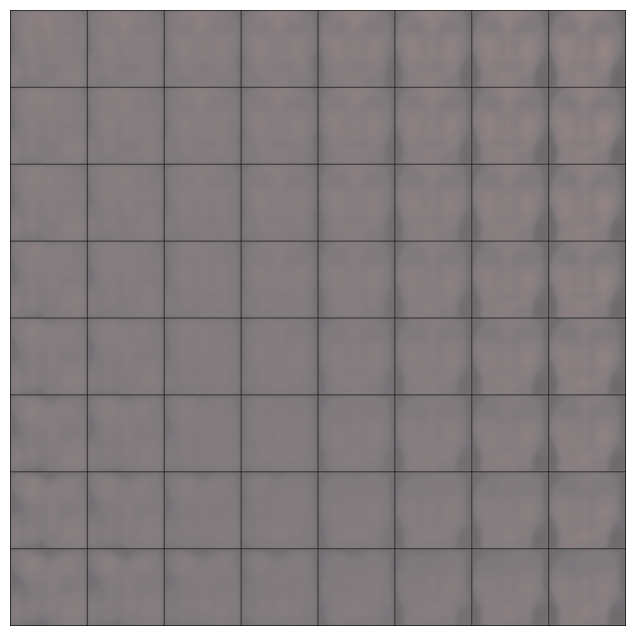

In [30]:
# 1. Меняем 0-й и 1-й признак
z = generate_manual_z(fixed_value=0.0, vary_dims=(0, 1), range_min=-3, range_max=3)
generate_face_grid(z, save_path=f'{GRID_FOLDER}/grid_faces_0_1.png')

Сетка лиц сохранена в ./output\grid/grid_faces_2_3.png


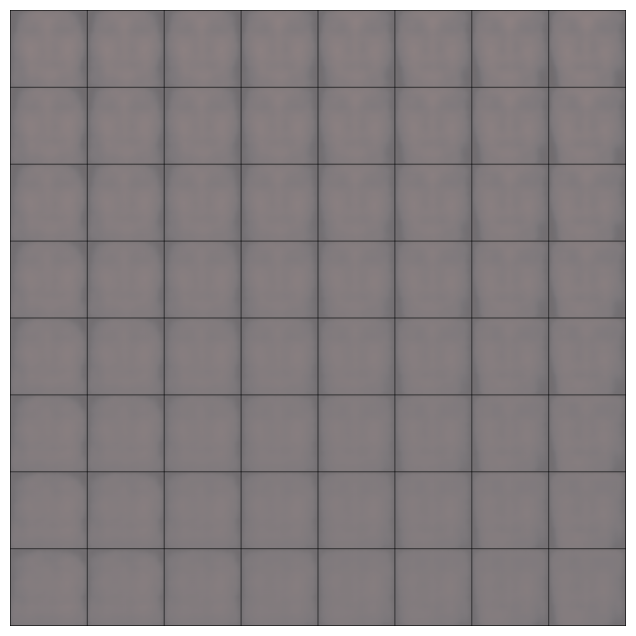

In [31]:
# 2. Меняем 2-й и 3-й признак
z = generate_manual_z(fixed_value=0.0, vary_dims=(2, 3), range_min=-2, range_max=2)
generate_face_grid(z, save_path=f'{GRID_FOLDER}/grid_faces_2_3.png')



Сетка лиц сохранена в ./output\grid/grid_faces_5_6.png


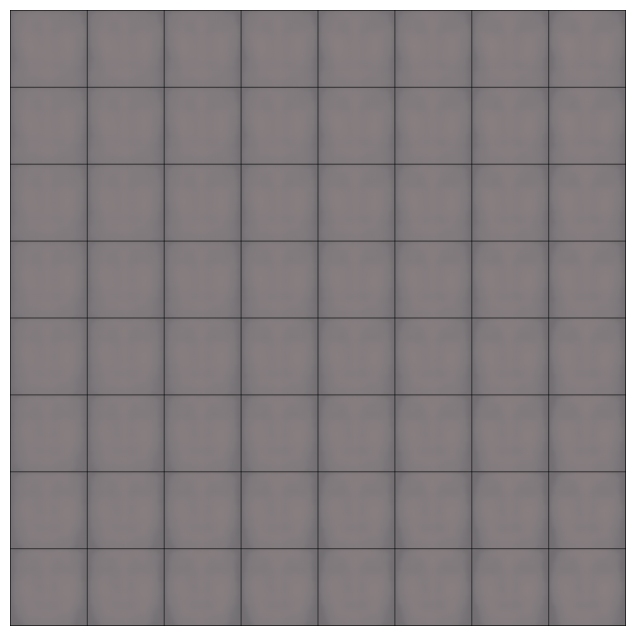

In [32]:
# 3. Узкий диапазон изменений для тонких вариаций
z = generate_manual_z(fixed_value=0.0, vary_dims=(5, 6), range_min=-1, range_max=1)
generate_face_grid(z, save_path=f'{GRID_FOLDER}/grid_faces_5_6.png')



In [33]:
# 4. Генерация анимации перемещения по латентному пространству
generate_latent_animation(vary_dims=(0, 1), steps=40, save_path=f'{OUTPUT}/latent_walk.gif')


Анимация латентного перехода сохранена в ./output/latent_walk.gif
